## Part 1

In [1]:
from scipy.special import beta
import numpy as np

a = 0
b = 10
c = 100

E = (a + 4*b + c)/6
var = (E - a) * (c - E) / 7
print(f"E[X] = {E}")
print(f"var[X] = {var}")

def p(x, a=0, b=10, c=100):
    x = np.array(x, dtype=np.float64)

    alpha = 1 + 4 * (b - a) / (c - a)
    beta_ = 1 + 4 * (c - b) / (c - a)

    pdf = np.zeros_like(x)
    mask = (x >= a) & (x <= c)

    num = (x[mask] - a) ** (alpha - 1) * (c - x[mask]) ** (beta_ - 1)
    denom = beta(alpha, beta_) * (c - a) ** (alpha + beta_ - 1)

    pdf[mask] = num / (denom + 1e-8)
    return pdf

E[X] = 23.333333333333332
var[X] = 255.55555555555557


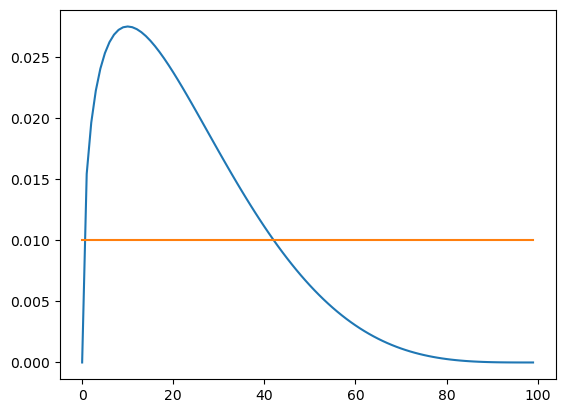

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x_vec = np.arange(a,c,1)
vals = [p(x) for x in x_vec]
plt.plot(x_vec, vals)
plt.plot(x_vec, np.ones_like(x_vec) / len(x_vec))

### 1.1

In [3]:
def expected_value_integrand_p(x):
    return p(x) * x

def trapezoidal(fun, x0, xn, n):
    interval = (xn - x0) / n
    integral = 0
    
    x_prev = x0

    for x in np.arange(x0 + interval, xn + interval / 10, interval):
        integral += (x - x_prev)/2 * (fun(x) + fun(x_prev))

        x_prev = x

    return integral

for n in range(1,500):
    diff = np.abs(E - trapezoidal(expected_value_integrand_p, a, c, n)) 
    if diff < 5e-5:
        print(f"Difference between actual E[X] and approximated")
        print("---------------------------------------------------------")
        print(f"E[x] - E_hat[X] = {diff} using {n} samples")
        break

Difference between actual E[X] and approximated
---------------------------------------------------------
E[x] - E_hat[X] = 4.957722734388881e-05 using 271 samples


### 1.2 was done by hand

### 1.3

In [4]:
np.random.seed(42)


for _ in range(10):
    n = 9413605

    estimates = []

    x = np.random.uniform(0,100, size=n)
    fx = 100 * expected_value_integrand_p(x)

    print(f"Average: {np.mean(fx) :.5f}")
    print(f"Std: {np.std(fx) / np.sqrt(n)}")

    # Actual diff
    diff = np.abs(np.mean(fx) - E)
    print(f"Diff: {diff}")

Average: 23.32883
Std: 0.006218402351641426
Diff: 0.004503095774506249
Average: 23.33704
Std: 0.0062189591921063166
Diff: 0.003706061934558136
Average: 23.33190
Std: 0.006217868607202644
Diff: 0.001429876031000532
Average: 23.34266
Std: 0.0062181012237719465
Diff: 0.009329383188394047
Average: 23.32511
Std: 0.006217777475922076
Diff: 0.008219199737659721
Average: 23.33438
Std: 0.006218744849493911
Diff: 0.001049479415573984
Average: 23.33460
Std: 0.006218773351427213
Diff: 0.0012709988174677278
Average: 23.34622
Std: 0.006219525760537308
Diff: 0.012887610715907272
Average: 23.33935
Std: 0.006218308108640831
Diff: 0.006012959370949034
Average: 23.33824
Std: 0.006218719693825996
Diff: 0.0049100018161070125


-0.031087913159705494


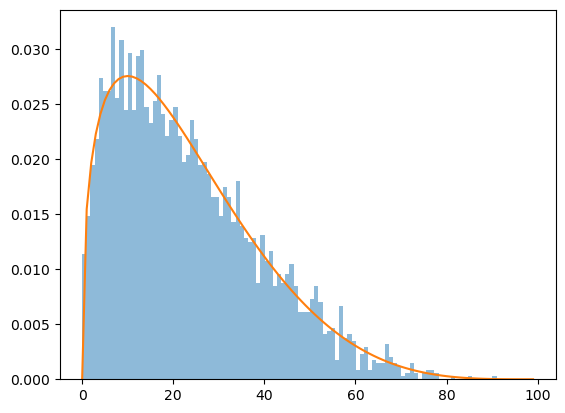

In [5]:
np.random.seed(42)
# Rejection sampling
M = 3
n = 11317

x = np.random.uniform(a,c, size=n)

u = np.random.uniform(0, M * 1 / (c -a), size=n)

# Accept 
accepted = u < p(x)
samples = x[accepted]

print(np.mean(samples) - E)

plt.hist(samples, bins=100, alpha=0.5, label='u samples', density=True)
plt.plot(x_vec, vals)
plt.show()

## Part 2

### 2.1

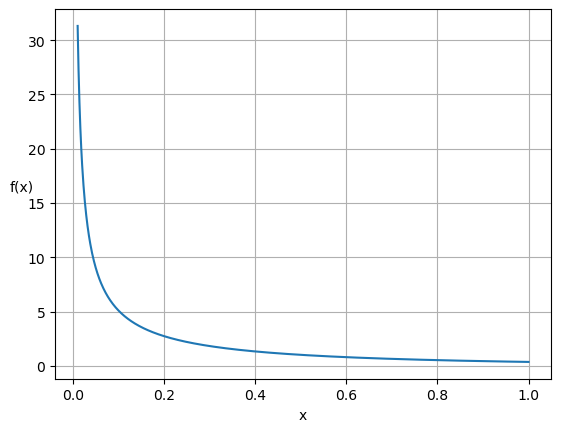

In [6]:
def integrand(x):
    return x**(-3/4) * np.exp(-x)

x = np.linspace(1e-2,1, 1000)
plt.plot(x, integrand(x))
plt.xlabel("x")
plt.ylabel("f(x)", rotation=0)
plt.grid(True)

### 2.2

In [ ]:
np.random.seed(42)
n = 10**7

# estimates = []

for _ in range(10):
    x = np.random.uniform(0,1, size=n)
    fx = integrand(x)
    print(f"{np.mean(fx)} +/- {np.std(fx) / np.sqrt(n)}")


3.358766787316318 +/- 0.02620844516946836
3.285987749288469 +/- 0.023660974581962632
3.4207903442834726 +/- 0.06634129738738355
3.4831710924054757 +/- 0.10556382554836441
3.3377648062618053 +/- 0.03379518231008055
3.5080304977219203 +/- 0.20198770658959941
3.2544720116910506 +/- 0.016958891963915274
3.4400995683493942 +/- 0.10902066045137224
3.292697900578018 +/- 0.023452572670682733
3.257779094394792 +/- 0.0195474699750726


### 2.3

In [8]:
def q(x, c = 1/4):
    return c * x**(-3/4)

def q_cdf(x):
    return x**(1/4)

def q_cdf_inv(x):
    return x**4

np.random.seed(42)
n = 10**7
# estimates = []

for _ in range(10):
    u = np.random.uniform(0, 1, size=n)
    x = q_cdf_inv(u)  # samples from q(x)
    fx = integrand(x)
    qx = q(x)
    weights = fx / qx


    print(f"{np.mean(weights)} +/- {np.std(weights) / np.sqrt(n)}")

3.379397296533405 +/- 0.00023749080058554998
3.3792457215379885 +/- 0.0002375050547221714
3.379584219207786 +/- 0.000237494834900706
3.379746817735184 +/- 0.00023739981096722022
3.3793575230762527 +/- 0.00023755736824890463
3.379461281845539 +/- 0.00023754720129126288
3.3795818867019003 +/- 0.00023752168878923716
3.3793813036846907 +/- 0.00023755903567675978
3.3793414394387735 +/- 0.00023752452057294253
3.3795648742870696 +/- 0.00023747629328670905


### 2.4 - maybe make a graph of both with uncertainties

## 3

### 3.1

In [43]:
def metropolis_hastings(log_posterior, initial, proposal_fn, iterations, data, use_asymmetric=False):
    samples = []
    current = np.array(initial)
    current_log_post = log_posterior(current[0], current[1], data)

    for _ in range(iterations):
        proposal = proposal_fn(current)
        proposal_log_post = log_posterior(proposal[0], proposal[1], data)

        log_accept_ratio = proposal_log_post - current_log_post

        if use_asymmetric:
            # Compute log of q(current | proposal) - log q(proposal | current)
            # Proposal: q(α′, η′ | α, η) = Exp(1/α) × Exp(1/η)
            alpha_c, eta_c = current
            alpha_p, eta_p = proposal

            log_q_current_given_prop = np.log(1 / alpha_p) - alpha_c / alpha_p + np.log(1 / eta_p) - eta_c / eta_p
            log_q_prop_given_current = np.log(1 / alpha_c) - alpha_p / alpha_c + np.log(1 / eta_c) - eta_p / eta_c

            log_proposal_ratio = log_q_current_given_prop - log_q_prop_given_current
            log_accept_ratio += log_proposal_ratio

        accept_ratio = np.exp(log_accept_ratio)

        if np.random.rand() < accept_ratio:
            current = proposal
            current_log_post = proposal_log_post
        samples.append(current)

    return np.array(samples)


In [31]:
def log_posterior(alpha, eta, data):
    if alpha <= 0 or eta <= 0:
        return -np.inf

    log_likelihood = len(data) * (np.log(alpha) + np.log(eta)) \
                     + (alpha - 1) * np.sum(np.log(data)) \
                     - eta * np.sum(data ** alpha)

    log_prior = -alpha - 2 * eta + np.log(eta)
    return log_likelihood + log_prior

In [32]:
def normal_proposal_fn(cov):
    def proposal(current):
        return np.random.multivariate_normal(current, cov)
    return proposal

In [12]:
def proposal_distr():
    def proposal(current):
        alpha_curr, eta_curr = current
        alpha_new = np.random.exponential(scale=alpha_curr)
        eta_new = np.random.exponential(scale=eta_curr)
        return np.array([alpha_new, eta_new])
    return proposal

In [21]:
def print_mean_and_var(data, initial, proposal,iterations=10000,burn_in = 1000, cov = None, seed = 42):
    np.random.seed(seed)

    if cov is not None:
        proposal_fn = proposal(cov)

    else:
        proposal_fn = proposal()

    # Run MH
    samples = metropolis_hastings(log_posterior, initial, proposal_fn, iterations, data)

    # Discard burn-in
    samples = samples[burn_in:]

    # Extract α and η
    alpha_samples = samples[:, 0]
    eta_samples = samples[:, 1]

    # Print results
    print(f"Mean of α: {np.mean(alpha_samples):.4f}")
    print(f"Mean of η: {np.mean(eta_samples):.4f}")
    print(f"Variance of α: {np.var(alpha_samples):.4f}")
    print(f"Variance of η: {np.var(eta_samples):.4f}")


    return samples

In [33]:
data = np.array([0.3, 0.5, 0.75, 0.4])
initial = [1.0, 1.0]
cov =np.array( [[0.1,0], [0,0.1]])

covariances = [
    np.array([[0.01, 0], [0, 0.01]]),
    np.array([[0.05, 0], [0, 0.05]]),
    np.array([[0.1, 0], [0, 0.1]]),
    np.array([[1.0, 0], [0, 1.0]]),
    np.array([[0.1, 0.05], [0.05, 0.1]]),
    np.array([[0.1, 0.08], [0.08, 0.1]])
]

samples_all = []

for cov in covariances:
    print("------------------")
    print("Covariance:\n", cov)
    samples = print_mean_and_var(data, initial, normal_proposal_fn, cov=cov)

    samples_all.append(samples)
    

print("------------------")
print("proposal distribution ")
print_mean_and_var(data, initial, proposal_distr)


------------------
Covariance:
 [[0.01 0.  ]
 [0.   0.01]]
Mean of α: 1.8656
Mean of η: 2.0170
Variance of α: 0.7025
Variance of η: 1.4171
------------------
Covariance:
 [[0.05 0.  ]
 [0.   0.05]]
Mean of α: 1.7843
Mean of η: 1.8494
Variance of α: 0.5317
Variance of η: 0.7712
------------------
Covariance:
 [[0.1 0. ]
 [0.  0.1]]
Mean of α: 1.7852
Mean of η: 1.8572
Variance of α: 0.5071
Variance of η: 0.6067
------------------
Covariance:
 [[1. 0.]
 [0. 1.]]
Mean of α: 1.7685
Mean of η: 1.8386
Variance of α: 0.4383
Variance of η: 0.6380
------------------
Covariance:
 [[0.1  0.05]
 [0.05 0.1 ]]
Mean of α: 1.7367
Mean of η: 1.8429
Variance of α: 0.4696
Variance of η: 0.6684
------------------
Covariance:
 [[0.1  0.08]
 [0.08 0.1 ]]
Mean of α: 1.7398
Mean of η: 1.8739
Variance of α: 0.4504
Variance of η: 0.8049
------------------
proposal distribution 
Mean of α: 1.2284
Mean of η: 1.2432
Variance of α: 0.3300
Variance of η: 0.4106


array([[3.02508373, 2.27623512],
       [2.96607516, 1.93033561],
       [2.96607516, 1.93033561],
       ...,
       [1.40745016, 0.73065087],
       [1.40745016, 0.73065087],
       [1.40745016, 0.73065087]])

In [ ]:
for samples in samples_all:
    # Extract α and η samples
    alpha_samples = samples[:, 0]
    eta_samples = samples[:, 1]

    # Optional: plot traces
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_samples, label='α')
    plt.title("Trace of α")
    plt.subplot(1, 2, 2)
    plt.plot(eta_samples, label='η', color='orange')
    plt.title("Trace of η")
    plt.tight_layout()
    plt.show()

In [35]:
def exponential_proposal_fn():
    def proposal(current):
        alpha_curr, eta_curr = current
        alpha_prop = -alpha_curr * np.log(np.random.rand())
        eta_prop = -eta_curr * np.log(np.random.rand())
        return np.array([alpha_prop, eta_prop])
    return proposal

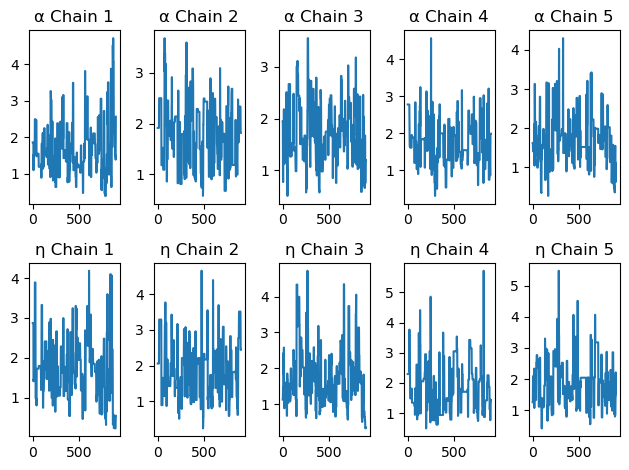

In [44]:
import matplotlib.pyplot as plt

def run_chains(n_chains=5, iterations=1000, burn_in=100, seed=42):
    np.random.seed(seed)
    data = np.array([0.3, 0.5, 0.75, 0.4])
    all_samples = []

    for chain_id in range(n_chains):
        initial = np.random.uniform(0.5, 2, size=2)
        samples = metropolis_hastings(
            log_posterior,
            initial,
            exponential_proposal_fn(),
            iterations,
            data,
            use_asymmetric=True
        )
        samples = samples[burn_in:]
        all_samples.append(samples)

        # Plot trace
        plt.subplot(2, n_chains, chain_id + 1)
        plt.plot(samples[:, 0])
        plt.title(f"α Chain {chain_id+1}")

        plt.subplot(2, n_chains, chain_id + 1 + n_chains)
        plt.plot(samples[:, 1])
        plt.title(f"η Chain {chain_id+1}")

    plt.tight_layout()
    plt.show()
    return all_samples

chains = run_chains()


In [48]:
def autocovariance(x, lag=100):
    n = len(x)
    x_mean = np.mean(x)
    acov = np.array([
        np.sum((x[:n-k] - x_mean) * (x[k:] - x_mean)) / n
        for k in range(lag)
    ])
    return acov

def effective_sample_size(samples):
    acov = autocovariance(samples, lag=100)
    var = acov[0]
    rho = acov[1:] / var
    # Use initial monotone sequence estimator (Geyer)
    t = 1 + 2 * np.sum(rho[rho > 0])
    return len(samples) / t


In [50]:
for i, samples in enumerate(chains):
    alpha, eta = samples[:, 0], samples[:, 1]
    ess_alpha = effective_sample_size(alpha)
    ess_eta = effective_sample_size(eta)
    print(f"Chain {i+1} ESS: for α: {ess_alpha:.2f}, for η: {ess_eta:.2f}")


Chain 1 ESS: for α: 76.59, for η: 60.42
Chain 2 ESS: for α: 66.49, for η: 67.10
Chain 3 ESS: for α: 63.43, for η: 42.76
Chain 4 ESS: for α: 78.25, for η: 45.51
Chain 5 ESS: for α: 68.73, for η: 69.97
